In [1]:
import scanpy as sc
import pandas as pd
import sys
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from pathlib import Path


In [2]:
# --- Configuration ---
os.chdir('/home/kl467102/thesis')
tf_file = '/home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv'
network_file = '/home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv'
network_name = 'STRING12'
beeline_dir = '/home/kl467102/thesis/BEELINE/'
beeline_dir = Path(beeline_dir)

### PBMC data

In [3]:
dataset_name = 'pbmc10k'
# Number of highly variable genes to select
n_top_hvg = 2000
# Whether to include HV TFs in the analysis
include_hv_tfs = True
tfs_suffix = 'TFs' if include_hv_tfs else ''
# Directory to save the processed data
output_dir = beeline_dir / 'inputs' / dataset_name
os.makedirs(output_dir, exist_ok=True)

In [4]:
param_prefix = output_dir / f"{dataset_name}_{network_name}_{n_top_hvg}{tfs_suffix}"


In [5]:
# --- 1. Load Data ---
data_dir = '/home/ajank/sc_GRN_reconstruction/data/pbmc_granulocyte_sorted_10k'
adata_rna = sc.read_10x_h5(data_dir+ '/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5')#, gex_only=False)
adata_rna.var_names_make_unique()

print(f"Initial AnnData shape: {adata_rna.shape}") # (cells, genes)

print(f"Reading TF list: {tf_file}")
tfs_df = pd.read_csv(tf_file, header=0)
all_known_tfs = set(tfs_df[tfs_df.columns[0]])

print(f"Reading network: {network_file}")
net_df = pd.read_csv(network_file)
print(f"Initial network shape: {net_df.shape}")


/home/kl467102/miniconda3/envs/sc_analysis/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Initial AnnData shape: (11898, 36601)
Reading TF list: /home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv
Reading network: /home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv
Initial network shape: (472000, 2)


/home/kl467102/miniconda3/envs/sc_analysis/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
## annotations
label_file = 'data/PBMC_label.txt' # path to cell-type annotations
label=pd.read_csv(label_file, sep='\t', header=0)

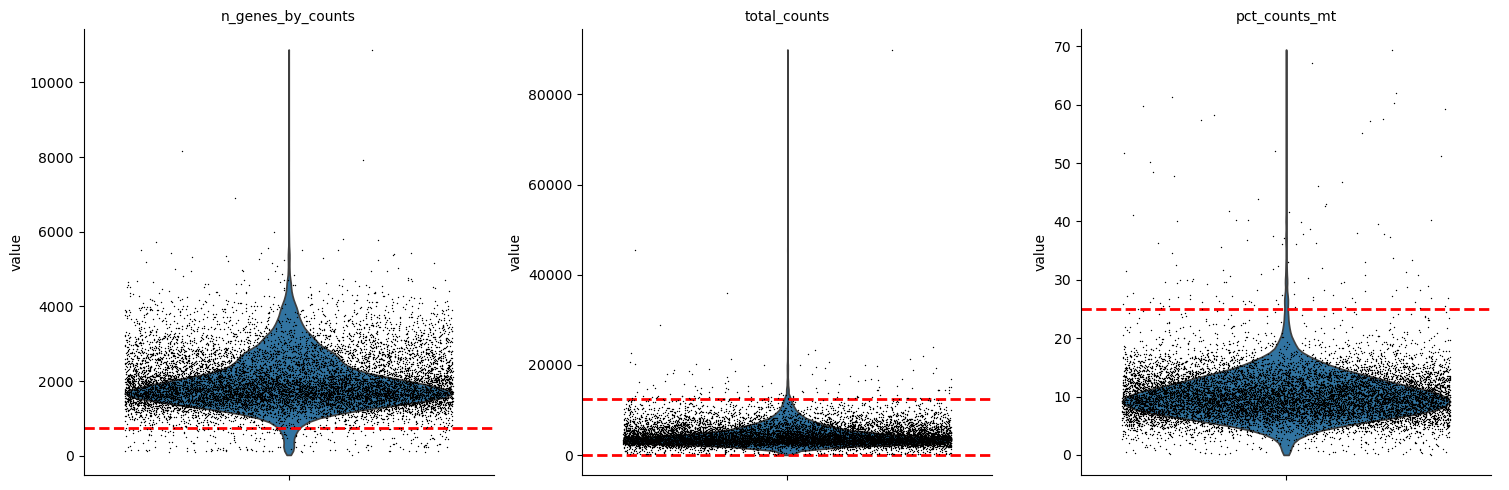

In [7]:
## --- 2. Preprocess Data ---

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_rna.var["mt"] = adata_rna.var_names.str.startswith("MT-")
# ribosomal genes
adata_rna.var["ribo"] = adata_rna.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_rna.var["hb"] = adata_rna.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata_rna, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

fig = sc.pl.violin(
    adata_rna,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    show=False 
)
min_genes = 750
min_counts = 4000 if dataset_name == 'kim23-dm1' else 100
max_counts = 12500
min_cells = 20
max_mt = 25

# Add horizontal lines to each subplot
axes = fig.axes.flat
lines = [min_genes, min_counts, max_mt] 

for ax, y in zip(axes, lines):
    ax.axhline(y, color='red', linestyle='--', linewidth=2)
axes[1].axhline(max_counts, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

In [8]:
sc.pp.filter_genes(adata_rna, min_cells=min_cells)
sc.pp.filter_cells(adata_rna, max_counts=max_counts)
sc.pp.filter_cells(adata_rna, min_genes=min_genes)

adata_rna = adata_rna[adata_rna.obs.pct_counts_mt < max_mt, :].copy()
adata_rna = adata_rna[:, ~adata_rna.var.mt].copy()

adata_rna.shape


(11474, 19435)

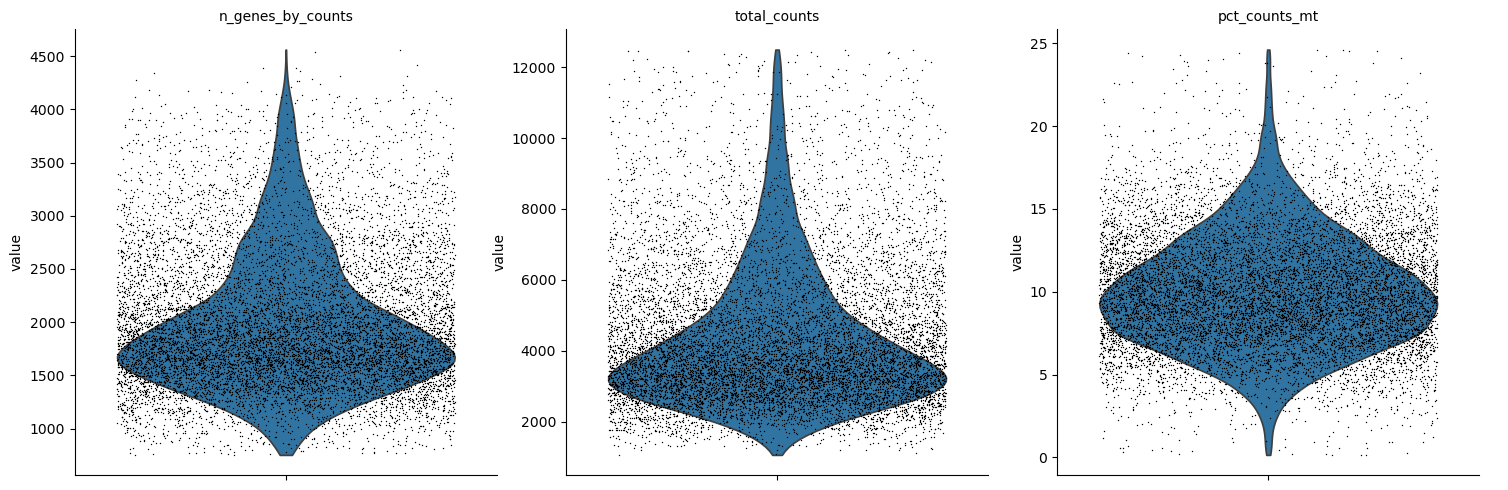

In [9]:
fig = sc.pl.violin(
    adata_rna,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)


In [10]:
adata_rna.obs['label'] = adata_rna.obs.index.map(label.set_index('barcode_use')['label'])
adata_rna.obs['label'] = adata_rna.obs['label'].fillna('Non-matched')


In [11]:
adata_rna

AnnData object with n_obs × n_vars = 11474 × 19435
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'label'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [12]:
# normalize and logarithmize
adata_rna.raw = adata_rna.copy()
adata_rna.layers['counts']=adata_rna.X.copy() 
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=None)


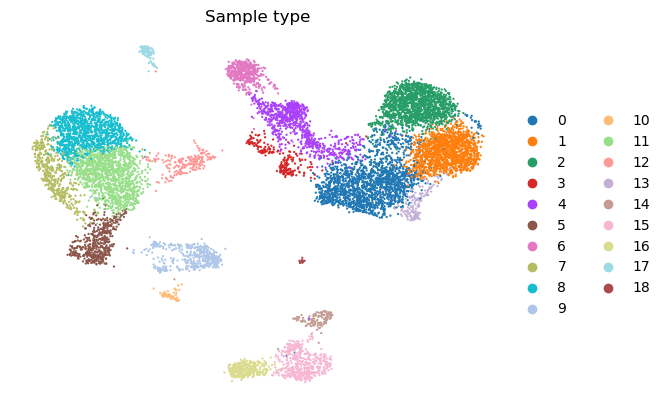

In [13]:
sc.tl.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna)
sc.tl.leiden(adata_rna, flavor="igraph")
sc.pl.umap(adata_rna, color="leiden", frameon=False,  title='Sample type')

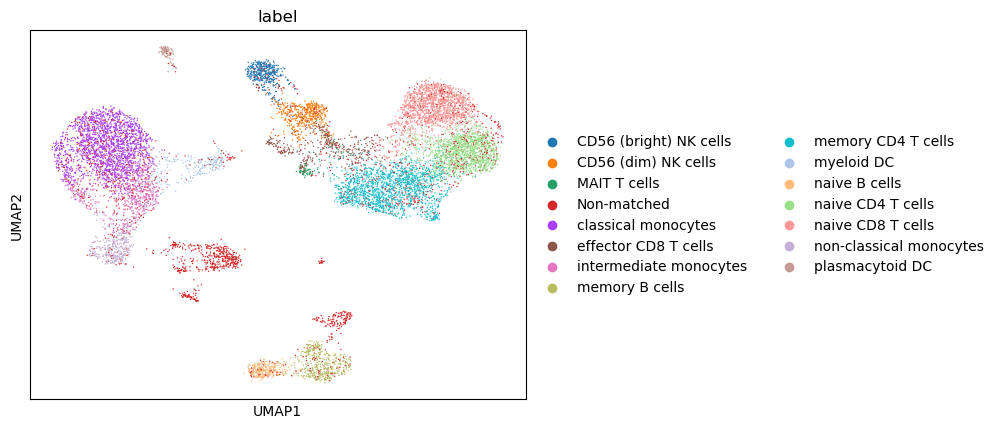

In [14]:
sc.pl.umap(
    adata_rna,
    color= 'label',
    #color= 'leiden',

    # Setting a smaller point size to get prevent overlap
    size=4,
)


In [15]:
adata_rna.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_counts,n_genes,label,leiden
AAACAGCCAAGGAATC-1,3308,8.104401,8380.0,9.033723,24.486874,31.957041,40.620525,54.952267,626.0,6.440947,...,1199.0,7.090077,14.307876,1.0,0.693147,0.011933,8370.0,3298,naive CD4 T cells,0
AAACAGCCAATCCCTT-1,1896,7.548029,3771.0,8.235361,26.067356,33.147706,42.879873,60.355343,397.0,5.986452,...,357.0,5.880533,9.466985,0.0,0.000000,0.000000,3767.0,1892,memory CD4 T cells,0
AAACAGCCAATGCGCT-1,2904,7.974189,6876.0,8.835938,24.447353,32.533450,41.157650,56.035486,444.0,6.098074,...,980.0,6.888573,14.252472,3.0,1.386294,0.043630,6867.0,2895,naive CD4 T cells,1
AAACAGCCACACTAAT-1,846,6.741701,1733.0,7.458186,39.180612,50.144259,62.435084,80.034622,312.0,5.746203,...,371.0,5.918894,21.407963,0.0,0.000000,0.000000,1733.0,846,Non-matched,2
AAACAGCCACCAACCG-1,2282,7.733246,5415.0,8.597113,26.943675,37.211450,47.442290,62.123730,352.0,5.866468,...,1136.0,7.036149,20.978762,1.0,0.693147,0.018467,5400.0,2269,Non-matched,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTAAAC-1,1525,7.330405,2866.0,7.961021,27.145848,34.193999,43.893929,64.235869,317.0,5.762052,...,177.0,5.181784,6.175855,0.0,0.000000,0.000000,2862.0,1521,naive CD8 T cells,2
TTTGTTGGTTAGGATT-1,2024,7.613325,4148.0,8.330623,23.866924,30.810029,40.597878,58.220829,412.0,6.023448,...,362.0,5.894403,8.727098,0.0,0.000000,0.000000,4143.0,2019,CD56 (bright) NK cells,6
TTTGTTGGTTGCAGTA-1,2116,7.657755,4834.0,8.483637,25.734381,34.691767,44.890360,61.026065,359.0,5.886104,...,842.0,6.736967,17.418287,0.0,0.000000,0.000000,4828.0,2110,Non-matched,0
TTTGTTGGTTGGTTAG-1,1620,7.390799,2976.0,7.998672,22.815860,31.283602,42.271505,62.365591,159.0,5.075174,...,374.0,5.926926,12.567204,0.0,0.000000,0.000000,2971.0,1615,memory CD4 T cells,0


In [16]:
adata = adata_rna[adata_rna.obs.label != 'Non-matched'].copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 9512 × 19435
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [18]:
adata_rna.raw

In [19]:
adata_path = output_dir / f"{dataset_name}.h5ad"
adata_rna.write(adata_path)
print(f"Saved processed AnnData to {adata_path}")
adata_rna = sc.read(adata_path)

Saved processed AnnData to /home/kl467102/thesis/BEELINE/inputs/pbmc10k/pbmc10k.h5ad


### Preparing input for Beeline

In [20]:
genes_in_data = set(adata_rna.var_names)
tfs_in_data = all_known_tfs.intersection(genes_in_data)
print(f"Found {len(tfs_in_data)} TFs present in the expression data.")

Found 1222 TFs present in the expression data.


In [21]:
sc.pp.highly_variable_genes(adata_rna, n_top_genes=None)
default_mask = adata_rna.var['highly_variable'].copy()
n_default = default_mask.sum()
print(f"Default HVGs: {n_default}")
# Cutoff HVGs
sc.pp.highly_variable_genes(adata_rna, n_top_genes=n_top_hvg)
cutoff_mask = adata_rna.var['highly_variable'].copy()
n_cutoff = cutoff_mask.sum()
print(f"Top {n_top_hvg} HVGs: {n_cutoff}")
# Include TFs
tf_mask = adata_rna.var_names.isin(all_known_tfs)
tf_in_default = default_mask & tf_mask
n_tf_default = tf_in_default.sum()
print(f"TFs in default HVGs: {n_tf_default}")
combined = cutoff_mask.copy()
if include_hv_tfs:
    combined |= tf_in_default
    added = combined.sum() - n_cutoff
    print(f"Including additional {added} TFs → total combined HVGs: {combined.sum()}")



Default HVGs: 3481
Top 2000 HVGs: 2000
TFs in default HVGs: 200
Including additional 94 TFs → total combined HVGs: 2094


In [22]:
os.makedirs(param_prefix, exist_ok=True)

In [24]:
ad_hvg

AnnData object with n_obs × n_vars = 11474 × 2094
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'label_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [34]:
ad_hvg = adata_rna[:, combined].copy()
ad_hvg_path = param_prefix / f"adata.h5ad"
ad_hvg.write(ad_hvg_path)
ad_hvg = sc.read(ad_hvg_path)
expr_df = pd.DataFrame(
    ad_hvg.X.toarray(),
    index=ad_hvg.obs_names,
    columns=ad_hvg.var_names
).T
print(f"HVG subset shape: cells={ad_hvg.n_obs}, genes={ad_hvg.n_vars}\n")
    
    
filtered_net_df = net_df[
    net_df['Gene1'].isin(ad_hvg.var.index) &
    net_df['Gene2'].isin(ad_hvg.var.index)
].copy()
filtered_net_df = filtered_net_df[filtered_net_df['Gene1'] != filtered_net_df['Gene2']]
filtered_net_df.drop_duplicates(keep='first', inplace=True)
expr_file = param_prefix / 'ExpressionData.csv'
expr_df.to_csv(expr_file, index=True)
filtered_network_filename = param_prefix / 'refNetwork.csv'
filtered_net_df.to_csv(filtered_network_filename, index=False)

print(f"Saved filtered expression data to {expr_file}")
print(f"Saved filtered network to {filtered_network_filename}")


HVG subset shape: cells=11474, genes=2094

Saved filtered expression data to /home/kl467102/thesis/BEELINE/inputs/pbmc10k/pbmc10k_STRING12_2000TFs/ExpressionData.csv
Saved filtered network to /home/kl467102/thesis/BEELINE/inputs/pbmc10k/pbmc10k_STRING12_2000TFs/refNetwork.csv
